In [41]:
!uv pip install linearmodels

Audited 1 package in 3ms


In [1]:
import pandas as pd

In [2]:
df_fin = pd.read_csv("./final_financials_trim.csv")
df_pred = pd.read_csv("./final_predictions.csv")

roa = b0 + b1\*score +b2\*confidence + b2\*filingsVol + b3\*ln(assets) + b4\*leverage + b5\*liquidity + b6\*pBRatio + b7\*ln(btcPrice) + b8\*ln(hashrate) + firmFixedEffects


In [ ]:
def get_fiscal_quarter(date_str):
    """Convert date string to fiscal quarter format (YYYYqQ)."""
    date = pd.to_datetime(date_str).to_period("Q")
    return date.strftime("%Yq%q")


df_pred["date"] = pd.to_datetime(
    df_pred["date"].astype("str").str.replace(r"\.md$", "", regex=True)
)
df_pred["quarter"] = df_pred["date"].apply(get_fiscal_quarter)

In [5]:
df_pred_agg = df_pred.groupby(["ticker", "quarter"]).agg(
    score_max=("score", "max"),
    score_mean=("score", "mean"),
    score_count=("score", "count"),
    confidence_max=("confidence", "max"),
    confidence_mean=("confidence", "mean"),
)
merged_df = pd.merge(df_fin, df_pred_agg, on=["ticker", "quarter"], how="inner")

In [6]:
merged_df.to_csv("./final_merged.csv", index=False)

In [7]:
merged_df["quarter_ts"] = pd.PeriodIndex(merged_df["quarter"], freq="Q").to_timestamp()
regression_df = merged_df.set_index(["ticker", "quarter_ts"])

In [8]:
regression_df

quarter       roa  log_assets  leverage  liquidity  \
ticker quarter_ts                                                      
ARLP   2025-07-01  2025q3  0.032700   21.790849  0.013213  32.486218   
       2025-04-01  2025q2  0.046462   21.777385  0.012920   0.019169   
       2025-01-01  2025q1  0.025487   21.788919  0.012799   0.028013   
       2024-10-01  2024q4  0.005601   21.793386  0.166956   0.046973   
       2024-07-01  2024q3  0.028455   21.832545  0.162401   0.064452   
...                   ...       ...         ...       ...        ...   
NCTY   2017-04-01  2017q2 -0.496449   19.523342  1.157006   0.011415   
       2017-01-01  2017q1 -0.674327   19.675989  0.968799   0.110798   
       2016-10-01  2016q4 -1.591270   19.675989  0.968799   0.110798   
       2015-10-01  2015q4 -0.714807   20.103546  0.310185   0.091082   
       2014-10-01  2014q4  0.066135   20.064193  0.005917   0.350805   

                    pb_ratio  log_btc_price  log_hashrate  score_max  \
ticker quarter_ts                                                      
ARLP   2025-07-01   1.554364      11.605403     20.878149        3.0   
       2025-04-01   1.539672      11.581615     20.630243        1.0   
       2025-01-01   1.602498      11.375819     20.584988        3.0   
       2024-10-01   1.612357      11.446106     20.581368        3.0   
       2024-07-01   1.427064      11.095719     20.339314        3.0   
...                      ...            ...           ...        ...   
NCTY   2017-04-01  -0.055420       7.840584     15.510817        0.0   
       2017-01-01  -0.073927       6.946755     15.219958        0.0   
       2016-10-01 -58.481220       6.835550     14.767149        0.0   
       2015-10-01 -20.153065       6.071269     13.596915        0.0   
       2014-10-01   0.475355       5.739793     12.654413        0.0   

                   score_mean  score_count  confidence_max  confidence_mean  
ticker quarter_ts                                                            
ARLP   2025-07-01         3.0            1            75.0             75.0  
       2025-04-01         1.0            1            10.0             10.0  
       2025-01-01         1.5            2           100.0             97.5  
       2024-10-01         1.5            2           100.0             85.0  
       2024-07-01         1.5            2           100.0             87.5  
...                       ...          ...             ...              ...  
NCTY   2017-04-01         0.0            1            95.0             95.0  
       2017-01-01         0.0            3           100.0            100.0  
       2016-10-01         0.0            1           100.0            100.0  
       2015-10-01         0.0            2           100.0            100.0  
       2014-10-01         0.0            2           100.0            100.0  

[534 rows x 13 columns]

H1, H3, H4:
formula = "roa ~ score_mean + score_count + log_assets + leverage + liquidity + pb_ratio + log_btc_price + log_hashrate"

H2:
formula = "roa ~ confidence_mean + score_count + log_assets + leverage + liquidity + pb_ratio + log_btc_price + log_hashrate"


In [29]:
from linearmodels import PanelOLS

formula = "roa ~ score_mean + score_count + log_assets + leverage + liquidity + pb_ratio + log_btc_price + log_hashrate"

mod = PanelOLS.from_formula(formula, data=regression_df)
res = mod.fit(cov_type="clustered", cluster_entity=True)
print(res)


                          PanelOLS Estimation Summary                           
Dep. Variable:                    roa   R-squared:                        0.6949
Estimator:                   PanelOLS   R-squared (Between):              0.9352
No. Observations:                 534   R-squared (Within):               0.6109
Date:                Thu, Dec 04 2025   R-squared (Overall):              0.6949
Time:                        05:12:57   Log-likelihood                   -954.33
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      149.72
Entities:                          27   P-value                           0.0000
Avg Obs:                       19.778   Distribution:                   F(8,526)
Min Obs:                       1.0000                                           
Max Obs:                       61.000   F-statistic (robust):           2.97e+04
                            

In [32]:
from linearmodels import PanelOLS

formula = "roa ~ confidence_mean + score_count + log_assets + leverage + liquidity + pb_ratio + log_btc_price + log_hashrate"

mod = PanelOLS.from_formula(formula, data=regression_df)
res = mod.fit(cov_type="clustered", cluster_entity=True)
print(res)


                          PanelOLS Estimation Summary                           
Dep. Variable:                    roa   R-squared:                        0.6998
Estimator:                   PanelOLS   R-squared (Between):              0.9191
No. Observations:                 534   R-squared (Within):               0.6157
Date:                Thu, Dec 04 2025   R-squared (Overall):              0.6998
Time:                        05:13:28   Log-likelihood                   -949.94
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      153.29
Entities:                          27   P-value                           0.0000
Avg Obs:                       19.778   Distribution:                   F(8,526)
Min Obs:                       1.0000                                           
Max Obs:                       61.000   F-statistic (robust):          1.871e+04
                            

In [37]:
regression_df = regression_df.drop("quarter", axis=1)

In [40]:
!uv pip install seaborn matplotlib

Audited 2 packages in 3ms


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

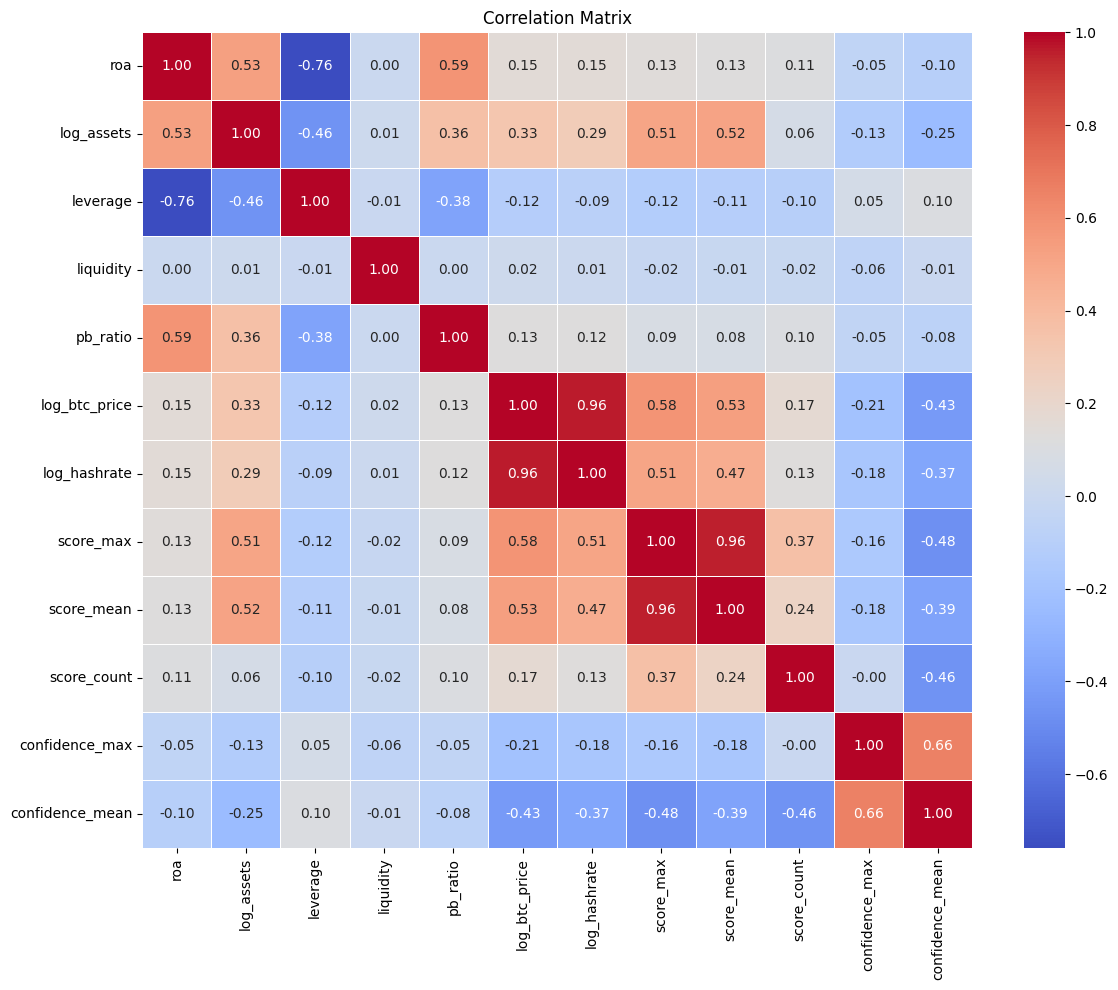

In [ ]:
plt.figure(figsize=(12, 10))  # Adjust figure size as needed
numeric_df = merged_df.select_dtypes(include="number")
sns.heatmap(
    numeric_df.corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

In [48]:
print(merged_df.describe())

              roa  log_assets    leverage   liquidity    pb_ratio  \
count  534.000000  534.000000  534.000000  534.000000  534.000000   
mean    -0.459738   18.468732    0.638809    0.223197   -4.407296   
min    -36.525694    8.530899    0.000000   -0.165147 -865.651000   
25%     -0.148248   16.672485    0.034483    0.028550    0.649882   
50%     -0.053415   18.375650    0.180545    0.093652    1.310426   
75%      0.002079   20.581396    0.388893    0.225246    2.915157   
max      3.814233   22.937389   42.710594   32.486218  414.121835   
std      2.577775    2.606290    2.981166    1.411851   63.800305   

       log_btc_price  log_hashrate   score_max  score_mean  score_count  \
count     534.000000    534.000000  534.000000  534.000000   534.000000   
mean        9.114258     17.235619    3.157397    2.376412     3.705993   
min        -2.813411     -4.522771    0.000000    0.000000     1.000000   
25%         8.334296     17.079850    0.000000    0.000000     1.250000   
50%

In [51]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ticker           534 non-null    object        
 1   quarter          534 non-null    object        
 2   roa              534 non-null    float64       
 3   log_assets       534 non-null    float64       
 4   leverage         534 non-null    float64       
 5   liquidity        534 non-null    float64       
 6   pb_ratio         534 non-null    float64       
 7   log_btc_price    534 non-null    float64       
 8   log_hashrate     534 non-null    float64       
 9   score_max        534 non-null    float64       
 10  score_mean       534 non-null    float64       
 11  score_count      534 non-null    int64         
 12  confidence_max   534 non-null    float64       
 13  confidence_mean  534 non-null    float64       
 14  quarter_ts       534 non-null    datetime6

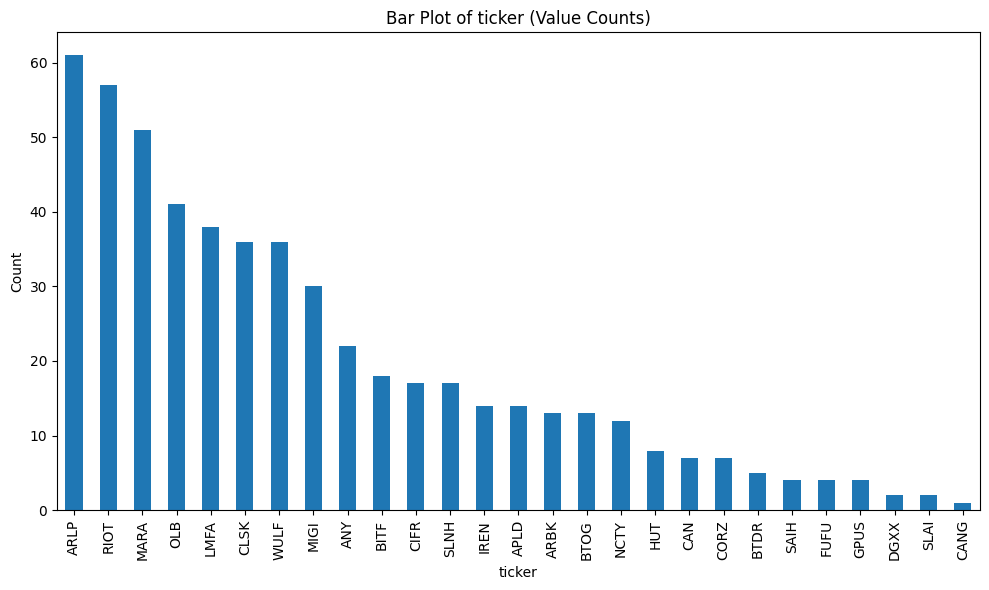

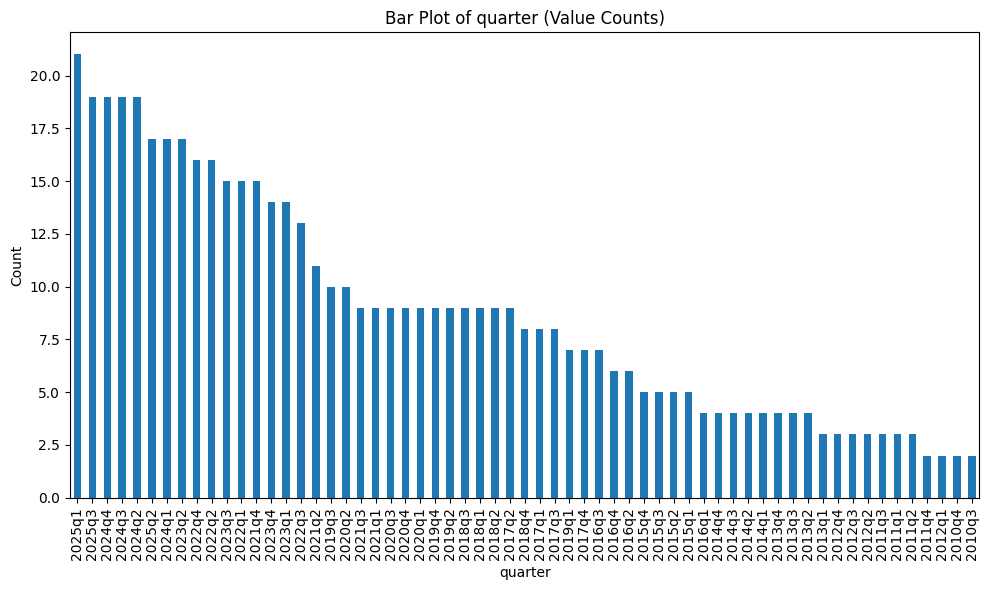

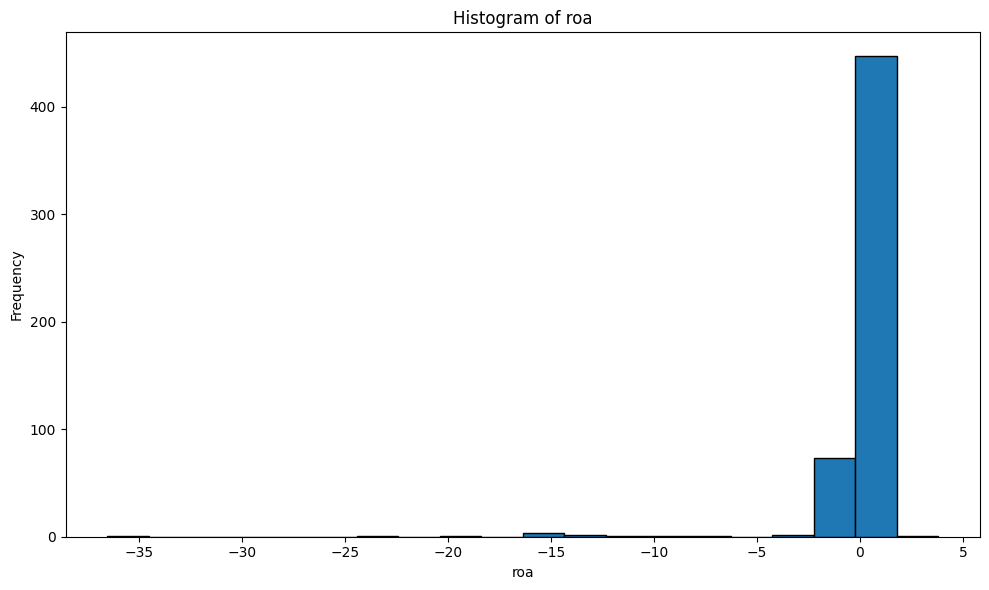

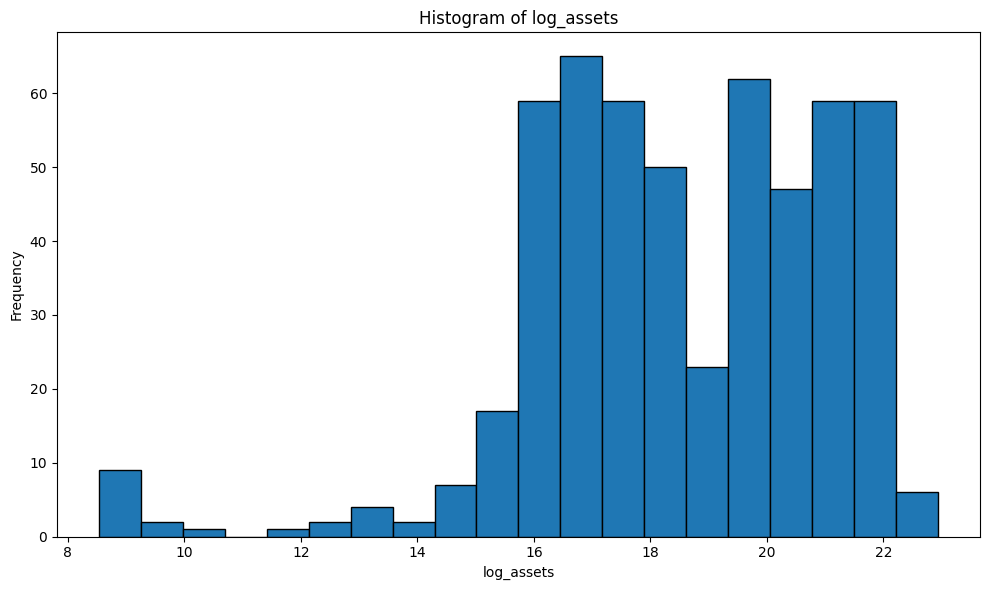

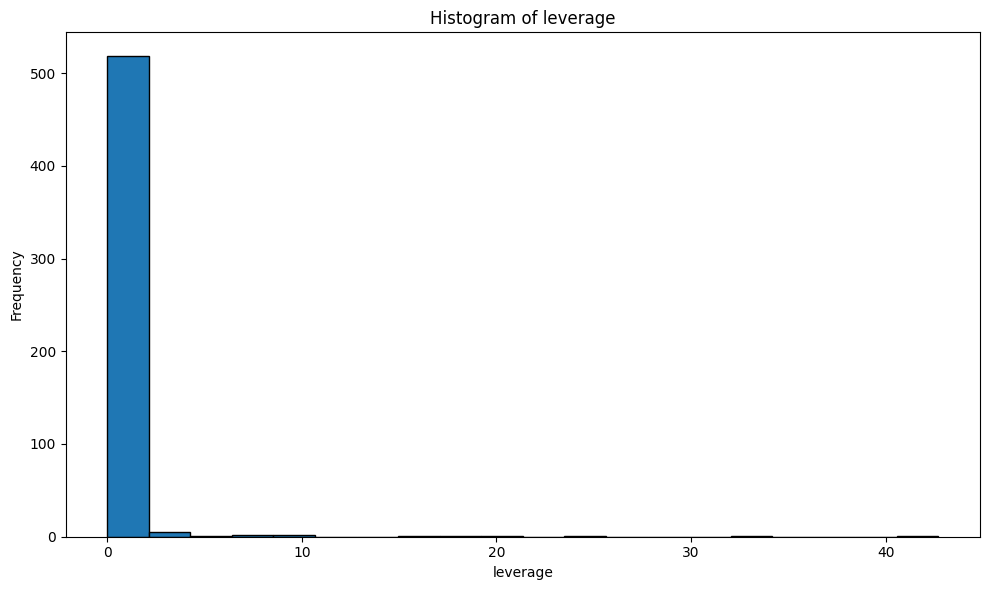

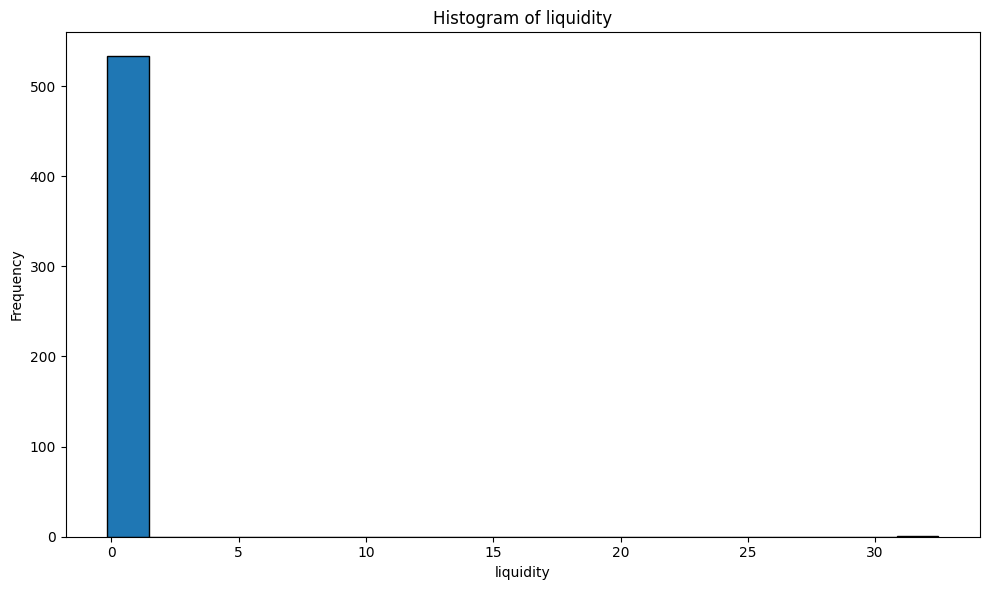

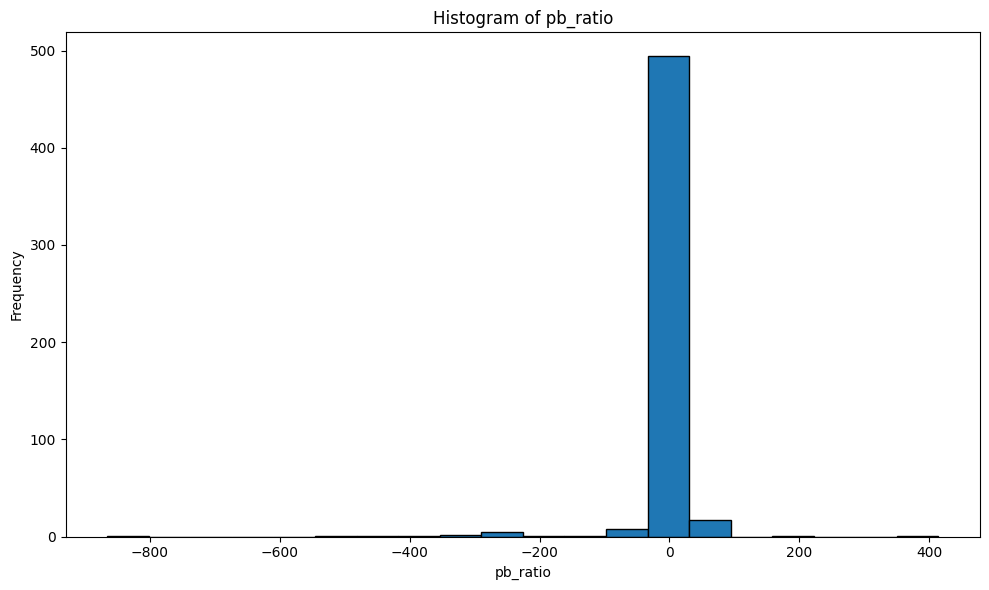

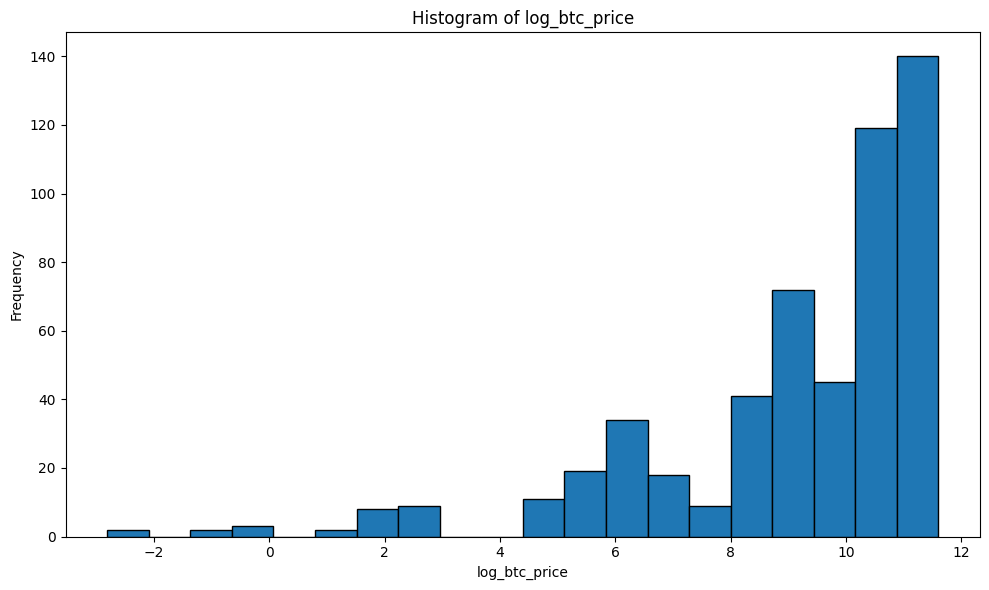

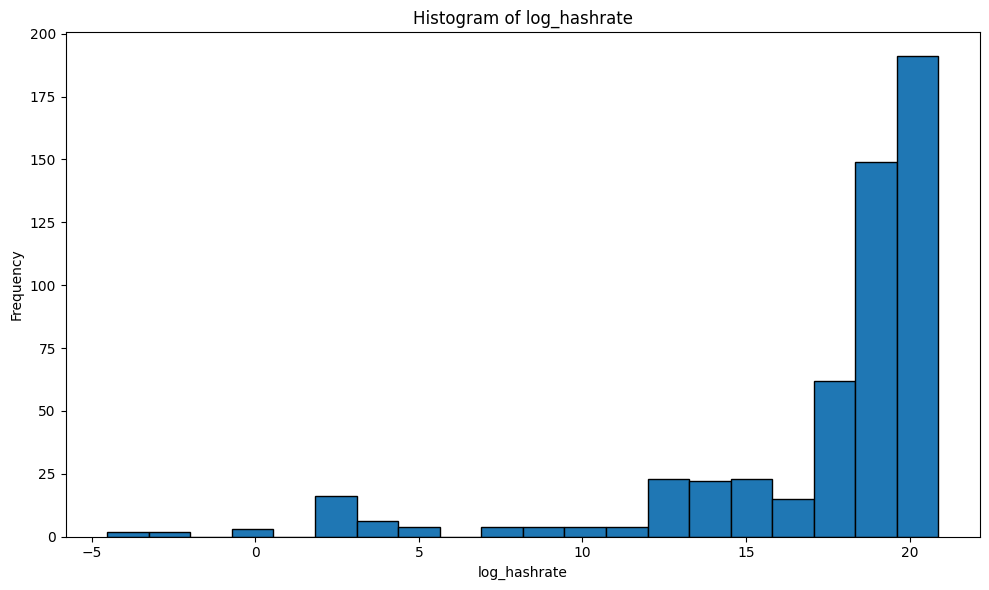

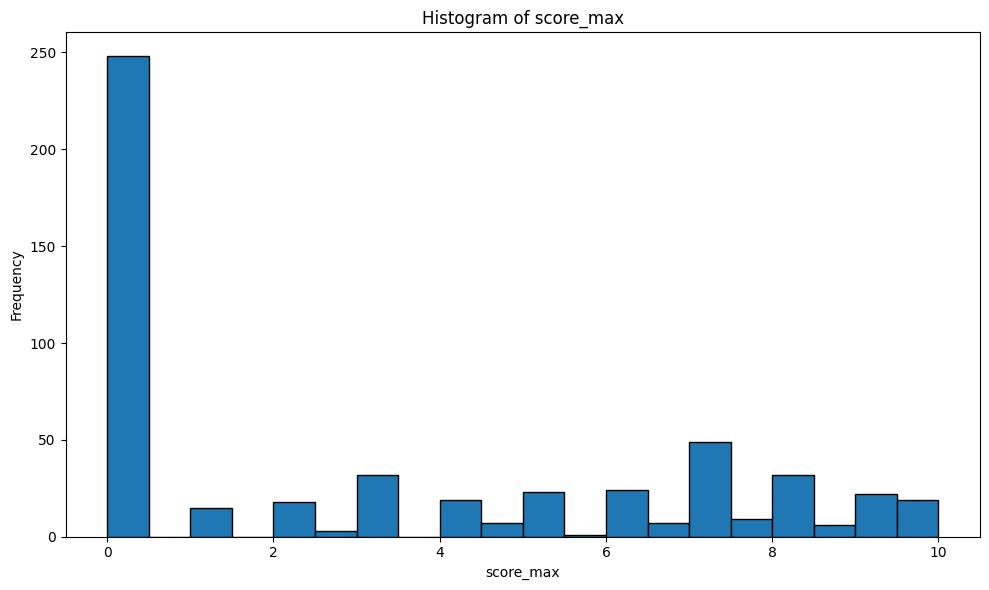

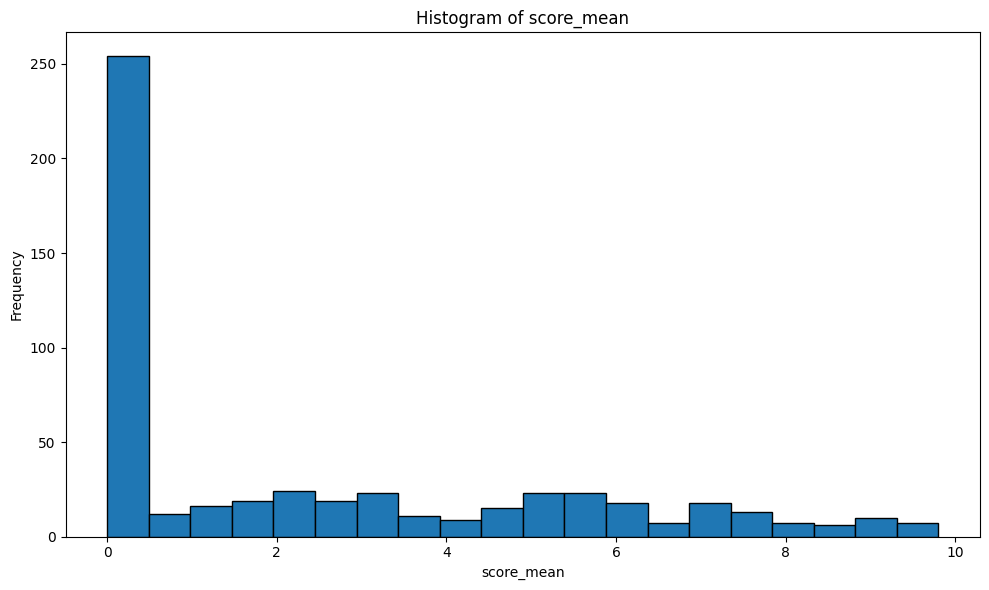

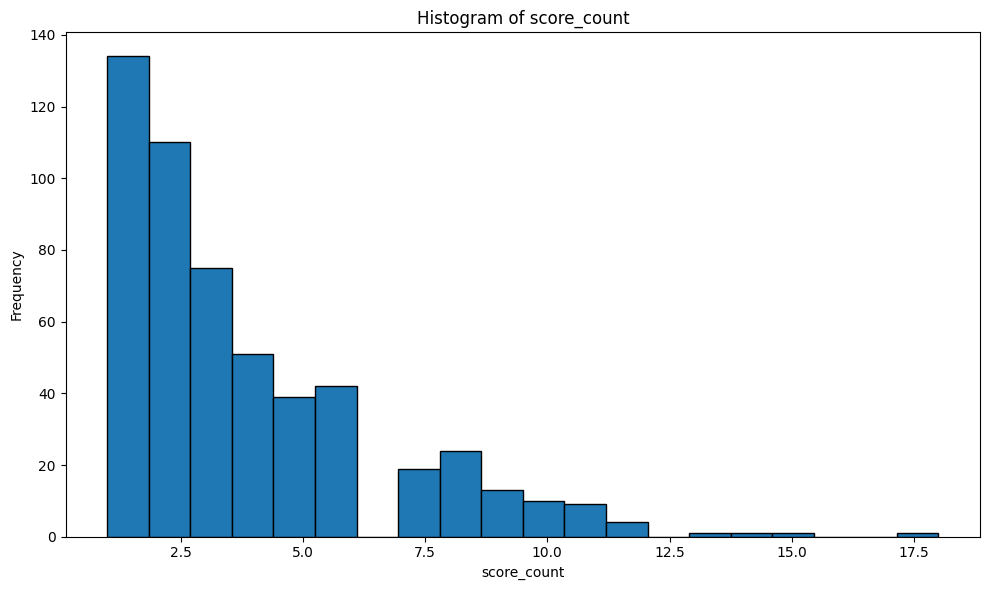

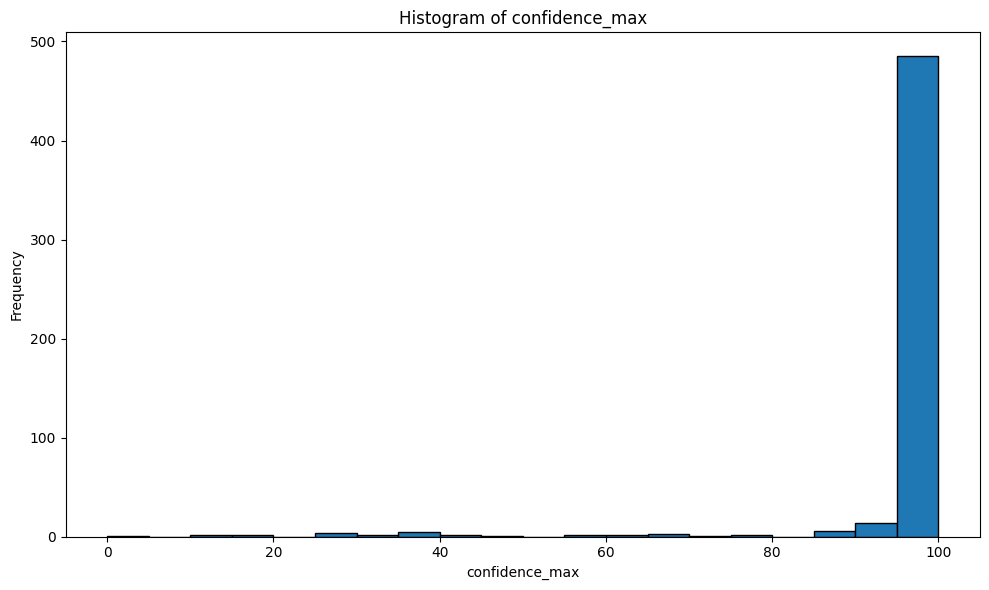

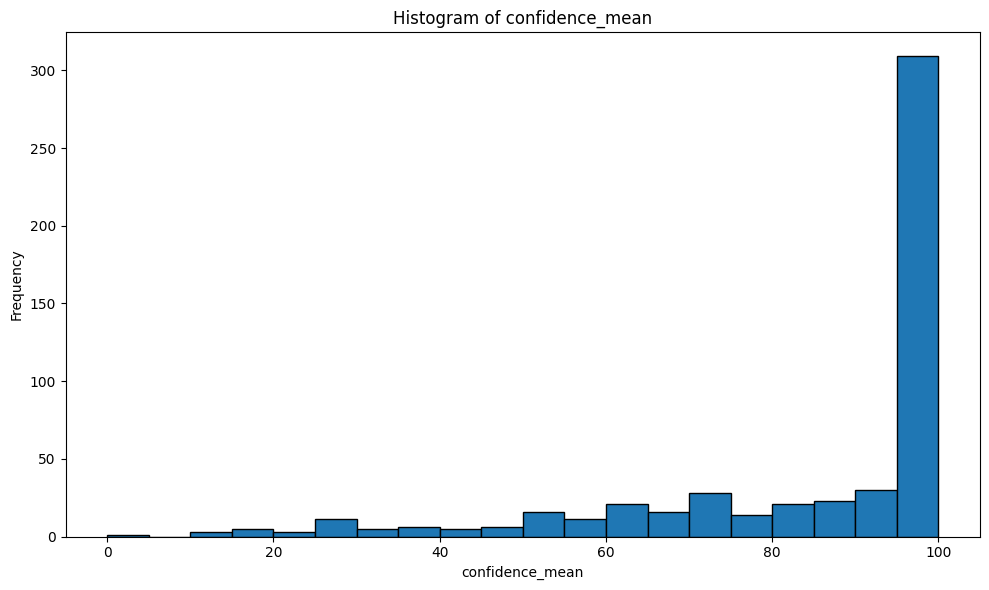

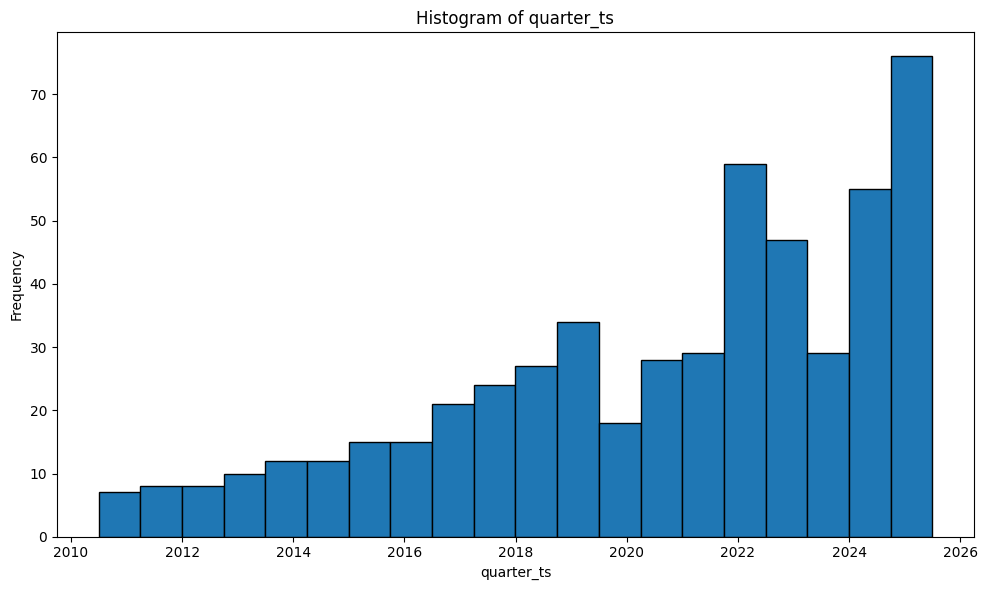

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you want bar graphs for each column in merged_df
# For categorical columns, this will show value counts
# For numeric columns, it will show binned counts (histogram-like)

for col in merged_df.columns:
    plt.figure(figsize=(10, 6))
    if merged_df[col].dtype == "object" or merged_df[col].dtype.name == "category":
        # For categorical columns, bar plot of value counts
        merged_df[col].value_counts().plot(kind="bar")
        plt.title(f"Bar Plot of {col} (Value Counts)")
        plt.xlabel(col)
        plt.ylabel("Count")
    else:
        # For numeric columns, histogram as bar plot
        plt.hist(merged_df[col].dropna(), bins=20, edgecolor="black")
        plt.title(f"Histogram of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()